Notebook for generating images to demonstrate base measurements that can be taken from segmented images.

In [2]:
import skimage
import czifile
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [4]:
# define helper function to print image in standard formatting
def print_im(image, h = 6, w = 6, save = False, f_name = ''):
    fig, ax = plt.subplots(figsize=(h, w))
    plt.axis("off")
    ax.imshow(image)
    plt.show()
    if save:
        plt.imsave(f_name, image)

(3, 10, 575, 575)


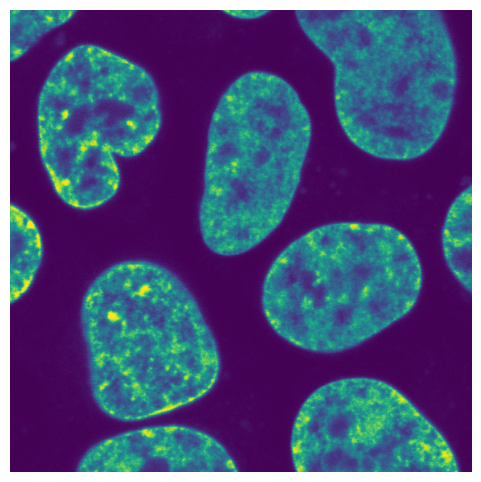

In [5]:
# read and preprocess the image
# example image is the hoechst channel of a z stack used for an experiment looking at mitochondrial mass
image_path = r'images\SCR_zstack_01.czi' #use slice 3
image = czifile.imread(image_path)
image = np.squeeze(image)
print(image.shape)

blue_slice = image[2, 3, :, :]
print_im(blue_slice, 6, 6)

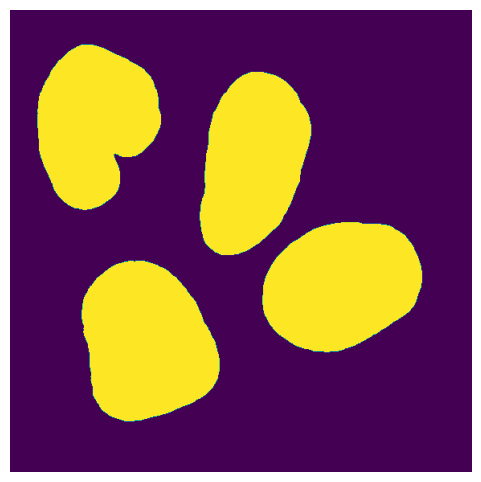

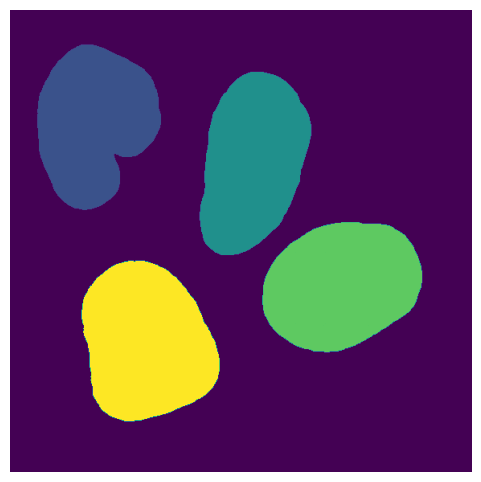

In [57]:
# preprocess and segment the image
blue_slice_blur = skimage.filters.gaussian(blue_slice) # gaussian blur to smooth
blue_slice_adjusted = skimage.exposure.equalize_hist(blue_slice_blur) # use histogram equalization for contrast adjustment
threshold = skimage.filters.threshold_otsu(blue_slice_adjusted) # otsu threshold
mask = blue_slice_adjusted > threshold # segment
# fill small holes to segment full nuclei
mask_filled = skimage.morphology.remove_small_holes(mask, area_threshold = 1750)
# remove anything touching the edges 
mask_no_edge = skimage.segmentation.clear_border(mask_filled)

# print segmented nuclei
print_im(mask_no_edge, 6, 6, save = True, f_name = 'nuclei_segmented.jpg')
# label and print nuclei
label_mask = skimage.measure.label(mask_no_edge)
print_im(label_mask, 6, 6, True, 'nuclei_labelled.jpg')


Attempt 1 - apply graphics for measurement in python and visualize with matplot

C:\Users\bensa\AppData\Local\Temp\ipykernel_33544\361504564.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


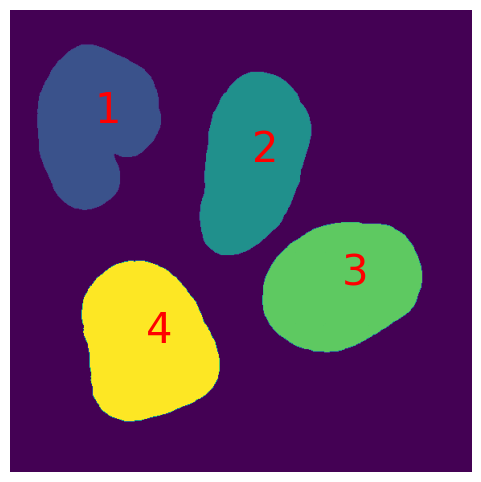

In [45]:
# apply graphics for counting
# show each labelled as a different color with a number on each object

label_mask = skimage.measure.label(mask_no_edge)
# get region properties for each object
regions = skimage.measure.regionprops(label_mask)
cell_num = 1
# number each object at the center of it
fig, ax = plt.subplots(figsize = (6,6))
plt.axis('off')
ax.imshow(label_mask)

for props in regions:
    y0, x0 = props.centroid
    # print a number for each
    ax.text(x0, y0, cell_num, size = 30, color = 'r')
    cell_num+=1

plt.savefig('counting.jpg')
fig.show()


96661.0


C:\Users\bensa\AppData\Local\Temp\ipykernel_33544\1784350179.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


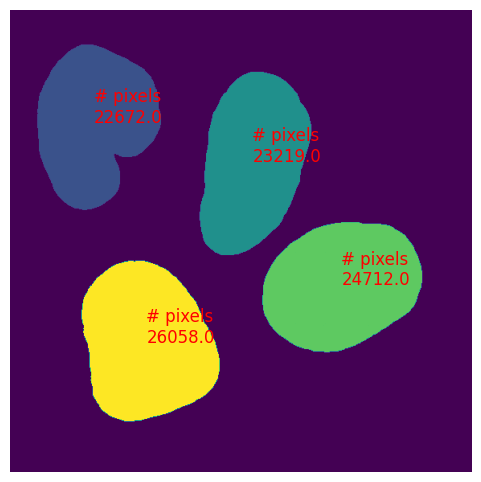

In [58]:
# apply graphic for surface area
# show # of pixels for each cell then print the total int he botton right of the image

label_mask = skimage.measure.label(mask_no_edge)

# get properties from each region
regions = skimage.measure.regionprops(label_mask)

# make a figure
fig, ax = plt.subplots(figsize = (6,6))
plt.axis('off')
ax.imshow(label_mask)
total = 0
for props in regions:
    y0, x0 = props.centroid
    area = props.area
    total += area
    text = '# pixels\n' + str(area)
    ax.text(x0, y0, text, size = 12, color = 'r')

fig.show()
print(total)


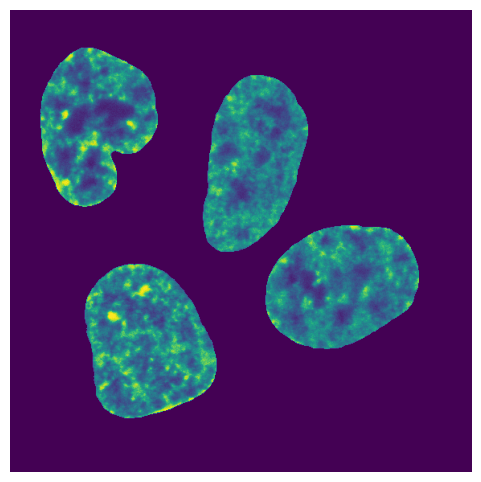

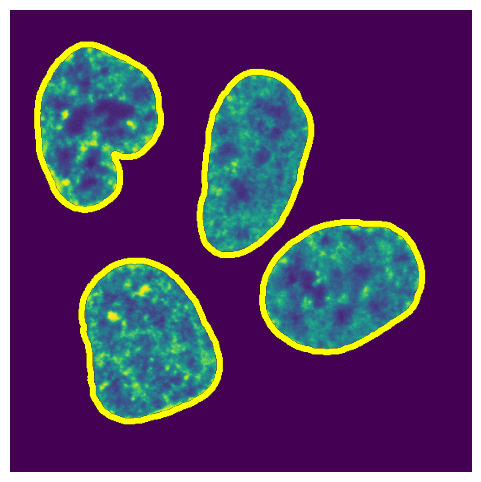

7598.528598865784


In [92]:
# generate raw image with just nuclei that were segmented
raw_under = blue_slice
raw_under[mask_no_edge == 0] = 0
print_im(raw_under)

#  pull outline from mask of nuclei
outline = skimage.filters.sobel(mask_no_edge)
outline_mask = outline > 0
outline_mask = skimage.morphology.binary_dilation(outline_mask, footprint = skimage.morphology.disk(3))
outline_mask = outline_mask.astype(raw_under.dtype)

outline_mask = skimage.morphology.binary_dilation(outline_mask, skimage.morphology.disk(0.95))


fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(raw_under, cmap='viridis')
ax.axis('off')

overlay = np.zeros((*raw_under.shape, 4))
overlay[outline_mask] = [1, 1, 0, 1]  # Red with full opacity (RGBA)
ax.imshow(overlay)
plt.savefig('mfi_base.jpg')
plt.show()

# get the mfi of the segmentation
mfi = np.mean(raw_under)
print(mfi)

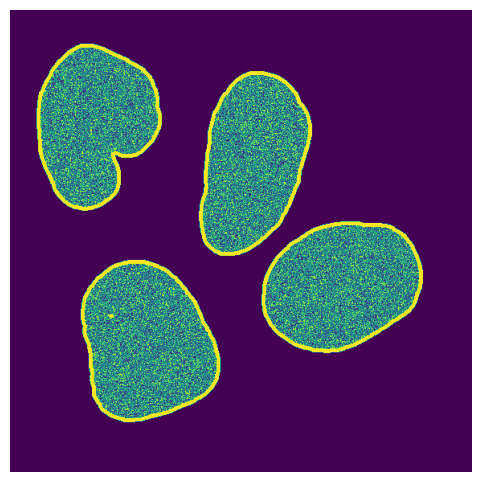

True


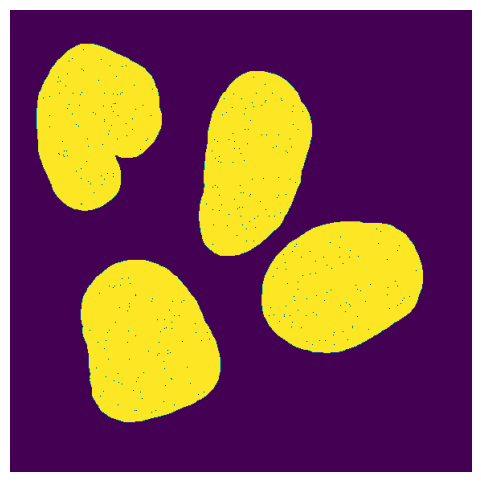

In [ ]:
import numpy as np
import cv2
from skimage import filters, morphology

def print_im(image, h=6, w=6, save=False, f_name=''):
    fig, ax = plt.subplots(figsize=(h, w))
    plt.axis("off")
    ax.imshow(image, cmap="viridis")
    plt.show()
    if save:
        plt.imsave(f_name, image)

# Step 1: Start from original image
raw_under = blue_slice.copy()
raw_under[mask_no_edge == 0] = 0  # apply mask
raw_under = raw_under.astype(np.uint8)  # ensure correct type

# Step 2: Convert grayscale to BGR
raw_under_bgr = cv2.cvtColor(raw_under, cv2.COLOR_GRAY2BGR)

# Step 3: Find contours
mask_uint8 = mask_no_edge.astype(np.uint8)
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: Draw magenta outlines (BGR: 255, 0, 255)
cv2.drawContours(raw_under_bgr, contours, -1, (255, 255, 255), 2)

# Step 5: Convert BGR to RGB for matplotlib display
raw_rgb = cv2.cvtColor(raw_under_bgr, cv2.COLOR_BGR2GRAY)

# Step 6: Display
print_im(raw_rgb)

raw_rgb = raw_rgb > 0.9

print(np.max(raw_rgb))


print_im(raw_rgb)



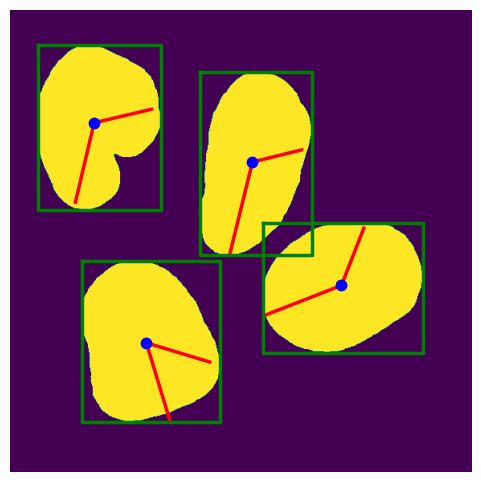

   centroid-0  centroid-1  orientation  axis_major_length  axis_minor_length
0  139.899568  104.228343    -0.231736         202.764281         146.977862
1  188.671347  301.300357    -0.241623         237.605328         125.780460
2  342.279540  412.037876    -1.198785         206.000548         152.953626
3  413.742075  169.214176     0.294019         204.617338         164.945367


In [37]:
# work on shape analysis markup
# create a bounding box and annotate the long and short poles of objects
# also maybe outline with a convex hull

raw_shape = blue_slice
raw_shape[mask_no_edge == 0] = 0



# label objects to get region props
label_mask = skimage.measure.label(mask_no_edge)

# grab shape and location properties from each labelled region
regions = skimage.measure.regionprops(label_mask)
# generate figure with the minor and major lengths of each object
fig, ax = plt.subplots(figsize = (6,6))
plt.axis('off')
ax.imshow(mask_no_edge)
for props in regions:
    # retrieve axis lengths
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 + math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 + math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 + math.cos(orientation) * 0.5 * props.axis_major_length
    # plot axis lengths and center over objects
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.b', markersize=15)
    # retrieve bounding box
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    #ax.plot(bx, by, color = '#F39C12', linewidth=2.5)
    ax.plot(bx, by, '-g', linewidth=2.5)
    # plot bounding box

plt.savefig('shape_analysis_no_labels.jpg')
plt.show()

# print properties as a table, then round axis lengths 
prop_table = skimage.measure.regionprops_table(
    label_mask,
    properties=('centroid', 'orientation', 'axis_major_length', 'axis_minor_length'),
)
prop_df = pd.DataFrame(prop_table)
print(prop_df)